In [1]:
import pandas as pd
import os
import time
from pathlib import Path
import gc
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
from datetime import datetime
from dateutil.relativedelta import FR
from dateutil.relativedelta import relativedelta

import numba
from numba import cuda
import cudf
import numpy as np
import numerapi
import matplotlib.pyplot as plt

# parallelize the process on all columns using joblib
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import lightgbm as lgb
from scipy import stats

from signalslite.data_utils import (
    load_recent_data_from_file,
    save_daily_data,
    save_in_folders,
    get_latest_date,
    read_available_dates
)
from signalslite.constants import Directories

In [2]:
dir_config = Directories()
dir_config.set_data_dir("../data/")

In [3]:
MERGED_HISTORICAL_DATA_LOCATION = os.path.join(dir_config.DATA_DIR, "merged_data_historical.parquet")
LIVE_DATA_LOCATION = os.path.join(dir_config.DATA_DIR, "merged_data_live.parquet")

In [4]:
ml_data = pd.read_parquet(MERGED_HISTORICAL_DATA_LOCATION)
live_data = pd.read_parquet(LIVE_DATA_LOCATION)

#ml_data = ml_data.groupby("date").filter(lambda x: len(x) > 500)

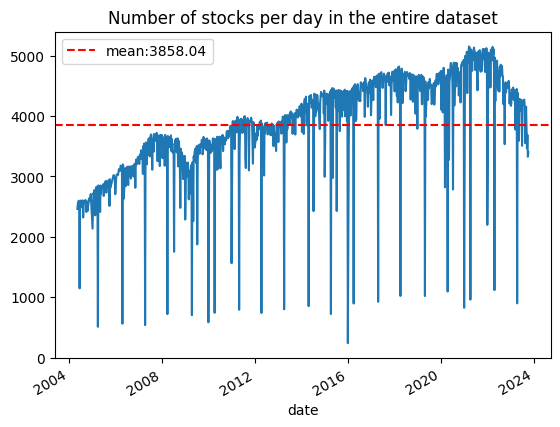

In [5]:
ml_data.groupby("date").apply(len).plot()
plt.title("Number of stocks per day in the entire dataset")
# horixzonal line at mean
mean_count = ml_data.groupby("date").apply(len).mean()
plt.axhline(mean_count, color="red", linestyle="--", label=f"mean:{round(mean_count, 2)}")
plt.legend()
plt.show()

In [6]:
hist_target = pd.read_csv("/mnt/d/nmr/signalslite/data/numerai_signals_historical.csv")

In [7]:
hist_target.columns

Index(['bloomberg_ticker', 'friday_date', 'data_type', 'target_4d',
       'target_20d', 'target_20d_raw_return', 'target_20d_factor_neutral',
       'target_20d_factor_feat_neutral', 'target_20d_camille',
       'target_20d_sydney', 'target_20d_irina', 'target_20d_alexandra',
       'target_20d_colleen', 'target_20d_jean', 'target_60d_camille',
       'target_60d_sydney', 'target_60d_irina', 'target_60d_alexandra',
       'target_60d_colleen', 'target_60d_jean'],
      dtype='object')

In [8]:
hist_lvl_1 = pd.read_parquet("/mnt/d/nmr/signalslite/data/01_daily_adjusted/2023/07/2023-07-21.parquet")
hist_lvl_2 = pd.read_parquet("/mnt/d/nmr/signalslite/data/02_primary_features/2023/07/2023-07-21.parquet")
hist_lvl_3 = pd.read_parquet("/mnt/d/nmr/signalslite/data/03_secondary_features/2023/07/2023-07-21.parquet")
hist_lvl_4 = pd.read_parquet("/mnt/d/nmr/signalslite/data/04_scaled_features/2023/07/2023-07-21.parquet")
hist_ml_data = ml_data[ml_data["friday_date"] == 20230721]
hist_tgt_data = hist_target[hist_target["friday_date"] == 20230721]

print("hist_lvl_1", hist_lvl_1.shape)
print("hist_lvl_2", hist_lvl_2.shape)
print("hist_lvl_3", hist_lvl_3.shape)
print("hist_lvl_4", hist_lvl_4.shape)
print("hist_ml_data", hist_ml_data.shape)
print("hist_tgt_data", hist_tgt_data.shape)

hist_lvl_1 (1085, 8)
hist_lvl_2 (7533, 67)
hist_lvl_3 (7306, 151)
hist_lvl_4 (7117, 147)
hist_ml_data (4264, 166)
hist_tgt_data (4943, 20)


In [9]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

class BaselineModel(RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

# 1. Provided Train-validation splits

In [10]:
ml_data["country"] = ml_data["bloomberg_ticker"].apply(lambda x: x.split(" ")[-1])
live_data["country"] = live_data["bloomberg_ticker"].apply(lambda x: x.split(" ")[-1])

ml_data["country"] = ml_data["country"].astype("category")
live_data["country"] = live_data["country"].astype("category")

In [11]:
train_set = ml_data[ml_data["data_type"] == "train"].copy()
val_set = ml_data[ml_data["data_type"] == "validation"].copy()

# embargo
last_train_date = train_set["date"].max()
# add embargoof 300 days
min_val_date = last_train_date + relativedelta(days=300)
val_set = val_set[val_set["date"] >= min_val_date].copy()

categorical_columns = ["country"]
feature_names = [c for c in train_set.columns if "feature_" in c]
feature_names += categorical_columns


# select features with "ratio" in name
# drop featires which have sma in name but not ratio
feature_names = [
    c
    for c in feature_names
    if not (("sma" in c or "ema" in c)and not "ratio" in c)
]
target_names = [c for c in train_set.columns if "target_" in c]

TARGET_NAME = "target_20d_factor_feat_neutral"
PREDICTION_NAME = "signal"

print(f"Using {len(feature_names)} features")
gc.collect()


Using 130 features


3526

In [12]:
lgb.__version__

'4.1.0'

In [13]:
import lightgbm as lgb
from tqdm import tqdm

MULTI_TARGET = True

# Assuming train_set is a pandas DataFrame and feature_names, target_names are lists of column names
train_features = train_set[feature_names]

callbacks = [lgb.log_evaluation(period=0)]

# Update LGBMRegressor parameters
lgbm_base_params = {
    'n_estimators': 20000,
    'learning_rate': 0.001,
    'random_state': 42,
    'subsample': 0.2,
    'colsample_bytree': 0.15,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'n_jobs': -1,
    # 'categorical_feature': categorical_columns,  # Uncomment if you have categorical columns
}

if MULTI_TARGET:
    # For MultiOutputRegressor, we need to fit the model differently
    # Fit each target separately using LightGBM's native format
    lgbm_models = {}
    for target in tqdm(train_set[target_names[1:]].columns):
        train_targets = train_set[target]
        lgb_train = lgb.Dataset(train_features, label=train_targets)
        lgbm_models[target] = lgb.train(lgbm_base_params, lgb_train, callbacks=callbacks)
else:
    train_targets = train_set[TARGET_NAME]
    lgb_train = lgb.Dataset(train_features, label=train_targets)
    # Use LightGBM's native fit method for single target
    lgbm_model = lgb.train(lgbm_base_params, lgb_train, callbacks=callbacks)


  0%|          | 0/16 [00:00<?, ?it/s]/home/surajp/miniconda3/envs/cudf/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.249861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 680
[LightGBM] [Info] Number of data points in the train set: 1444105, number of used features: 130
[LightGBM] [Info] Start training from score 0.501195


In [24]:
import numpy as np

TO_ENSEMBLE = True

# Function to aggregate predictions from multiple models
def aggregate_predictions(models, data, ensemble, index=3):
    # Collect predictions from each model
    all_preds = np.array([model.predict(data[feature_names]) for model in models.values()])

    # If ensembling, return the mean of predictions across all models
    if ensemble:
        return all_preds.mean(axis=0)
    # Else, return predictions from the model specified by the index
    else:
        return all_preds[index]

if MULTI_TARGET:
    # Adjust the logic for multi-target scenario
    if TO_ENSEMBLE:
        preds_train = aggregate_predictions(lgbm_models, train_set, ensemble=TO_ENSEMBLE)
        preds_val = aggregate_predictions(lgbm_models, val_set, ensemble=TO_ENSEMBLE)
        preds_live = aggregate_predictions(lgbm_models, live_data, ensemble=TO_ENSEMBLE)
    else:
        preds_train = aggregate_predictions(lgbm_models, train_set, ensemble=TO_ENSEMBLE, index=3)
        preds_val = aggregate_predictions(lgbm_models, val_set, ensemble=TO_ENSEMBLE, index=3)
        preds_live = aggregate_predictions(lgbm_models, live_data, ensemble=TO_ENSEMBLE, index=3)
else:
    # Single target scenario remains the same
    preds_train = lgbm_model.predict(train_set[feature_names])
    preds_val = lgbm_model.predict(val_set[feature_names])
    preds_live = lgbm_model.predict(live_data[feature_names])

# Assign predictions to the respective datasets
train_set.loc[:, PREDICTION_NAME] = preds_train
val_set.loc[:, PREDICTION_NAME] = preds_val
live_data.loc[:, PREDICTION_NAME] = preds_live

# Rank predictions
for dataset in [train_set, val_set, live_data]:
    dataset.loc[:, PREDICTION_NAME] = dataset.groupby("date")[PREDICTION_NAME].transform(lambda x: x.rank(pct=True))


/home/surajp/miniconda3/envs/cudf/lib/python3.10/site-packages/lightgbm/basic.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].cat.set_categories(category)
/home/surajp/miniconda3/envs/cudf/lib/python3.10/site-packages/lightgbm/basic.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].cat.set_categories(category)
/home/surajp/miniconda3/envs/cudf/lib/python3.10/site-packages/lightgbm/basic.py:693: SettingWithCopyWarning: 
A value is trying to be set on a co

In [25]:
def numerai_corr(preds, target):
    # rank (keeping ties) then Gaussianize predictions to standardize prediction distributions
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)

    # make targets centered around 0
    centered_target = target - target.mean()

    # raise both preds and target to the power of 1.5 to accentuate the tails
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
    target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5

    # finally return the Pearson correlation
    return np.corrcoef(preds_p15, target_p15)[0, 1]

def plot_scores(scores, rolling_window=4, is_tb=False):
    plt.figure(figsize=(15, 5))
    plt.plot(scores.rolling(rolling_window).mean(), label="Correlation")
    title = f"Correlation between predictions and target ({TARGET_NAME}); rolling mean last {rolling_window} days"
    if is_tb:
        title = "TB " + title
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Correlation")
    _mean = scores.mean()
    hit_rate = (scores > 0).mean()
    sortino = (scores.mean() + 1) / (scores[scores < 0].std() + 1)
    plt.axhline(
        _mean,
        color="blue",
        linestyle="--",
        linewidth=0.5,
        label=f"Mean ({_mean:.4f}); sharpe: {scores.mean() / scores.std():.2f}; hit rate: {hit_rate:.2f}; sortino: {sortino:.2f}",
    )
    plt.axhline(0, color="black", linestyle="--", linewidth=1)

    plt.legend()
    plt.show()


In [26]:
# take top and bottom 200 stocks in each date
def get_top_and_bottom(df, n=200):
    df = df.sort_values(PREDICTION_NAME)
    top = df.iloc[-n:]
    bottom = df.iloc[:n]
    return pd.concat([top, bottom])

train_set_top_and_bottom = train_set.groupby("date").apply(get_top_and_bottom).reset_index(drop=True)
val_set_top_and_bottom = val_set.groupby("date").apply(get_top_and_bottom).reset_index(drop=True)

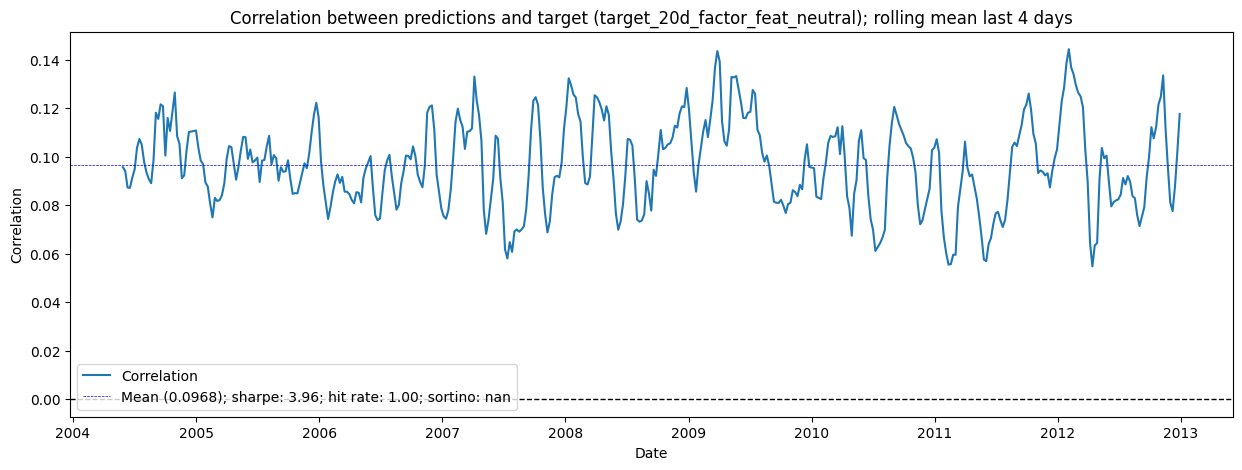

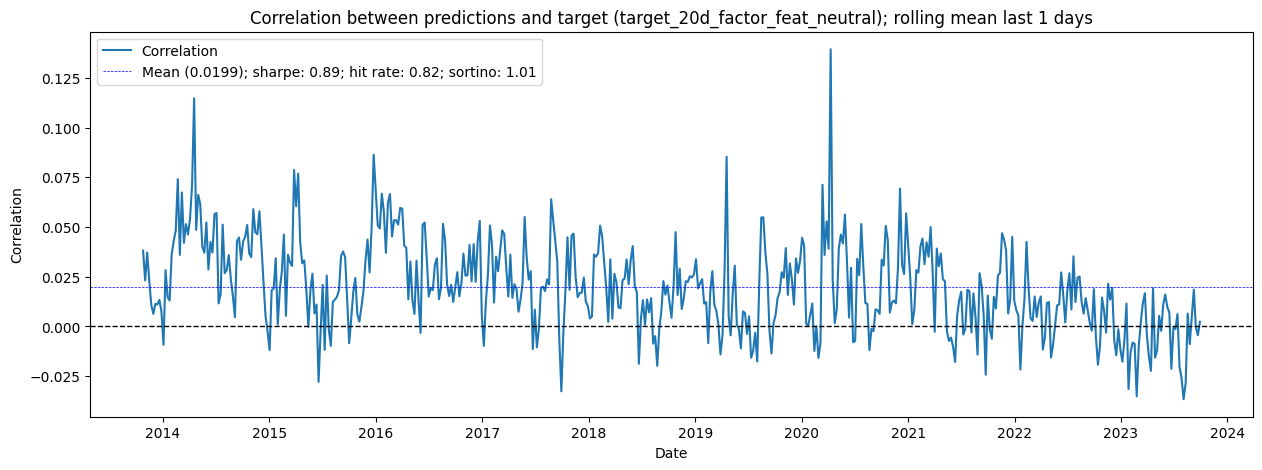

In [27]:
train_scores = train_set.groupby("date").apply(
    lambda x: numerai_corr(x[PREDICTION_NAME], x[TARGET_NAME])
)
val_scores = val_set.groupby("date").apply(
    lambda x: numerai_corr(x[PREDICTION_NAME], x[TARGET_NAME])
)
plot_scores(train_scores)
plot_scores(val_scores, rolling_window=1, is_tb=False)


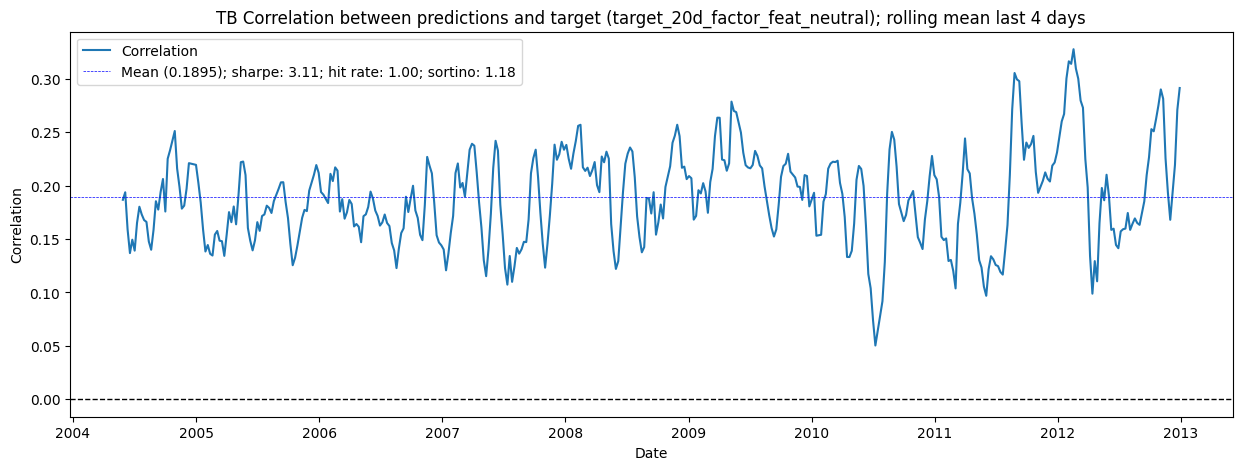

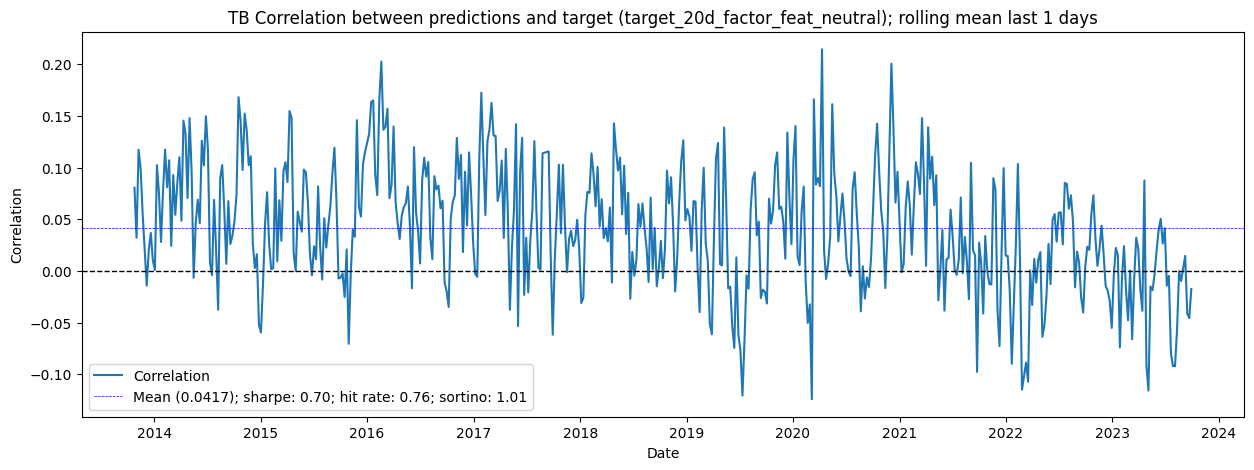

In [28]:
# calculate corr and plot

train_set_top_and_bottom_scores = train_set_top_and_bottom.groupby("date").apply(
    lambda x: numerai_corr(x[PREDICTION_NAME], x[TARGET_NAME])
)
val_set_top_and_bottom_scores = val_set_top_and_bottom.groupby("date").apply(
    lambda x: numerai_corr(x[PREDICTION_NAME], x[TARGET_NAME])
)
plot_scores(train_set_top_and_bottom_scores, is_tb=True)
plot_scores(val_set_top_and_bottom_scores, is_tb=True, rolling_window=1)

In [41]:
last_friday = datetime.now() + relativedelta(weekday=FR(-1))

diagnostic_df = pd.concat([val_set, live_data], axis=0)
diagnostic_df = diagnostic_df.drop_duplicates(
    subset=["bloomberg_ticker", "friday_date", "data_type"]
)
diagnostic_df["friday_date"] = diagnostic_df.friday_date.fillna(
    last_friday.strftime("%Y%m%d")
).astype(int)
diagnostic_df["data_type"] = diagnostic_df.data_type.fillna("live")

diagnostic_df[PREDICTION_NAME] = diagnostic_df.groupby("date")[PREDICTION_NAME].rank(
    pct=True, method="first"
)

Path("predictions").mkdir(parents=True, exist_ok=True)

diagnostic_df[["bloomberg_ticker", "friday_date", "data_type", "signal"]].reset_index(
    drop=True
).to_csv(
    f"predictions/signals_lgbm_500_train_val_set_{time.strftime('%Y%m%d_%H%M%S')}.csv",
    index=False,
)

# save only live data
diagnostic_df[diagnostic_df["data_type"] == "live"][
    ["bloomberg_ticker", "signal"]
].reset_index(drop=True).to_csv(
    f"predictions/signals_lgbm_200000_live_set_{time.strftime('%Y%m%d_%H%M%S')}.csv",
    index=False,
)